In [1]:
setwd(paste0(Sys.getenv('ROOT'), '/R'))

In [4]:
source('main.R')

combine.levels.OverallQual <- function (df) {
    df %>%
    mutate(
        quality = case_when(
            OverallQual %in% c(1, 2, 3, 4) ~ 1,
            OverallQual %in% c(9, 10) ~ 6,
            TRUE ~ OverallQual - 3
        )
    )
}

df.combined <- 
    kaggle.house$loadData() %>% 
    (kaggle.house$na$fixAll) %>%
    (kaggle.house$outliers$removeOutliers) %>%
    mutate(price.log = log(SalePrice)) %>%
    select(-SalePrice) 

df.combined.transformed <- 
    df.combined %>% 
    (kaggle.house$trans$transformCombindDataset) %>%
    combine.levels.OverallQual

trainset <- 
    df.combined.transformed %>% 
    filter(dataSource == "train") %>%
    select(-dataSource) %>%
    mutate(
        price = exp(price.log),
        sq.feat.price = price / GrLivArea,
        log.area = log(GrLivArea)
    )

testset <- 
    df.combined.transformed %>% 
    filter(dataSource == "test") %>%
    select(-dataSource, -price.log)

setdiff(trainset %>% colnames, testset %>% colnames)
setdiff(testset %>% colnames, trainset %>% colnames) %>% length

[1] "price.log"     "price"         "sq.feat.price" "log.area"

[1] 0

### Target variable

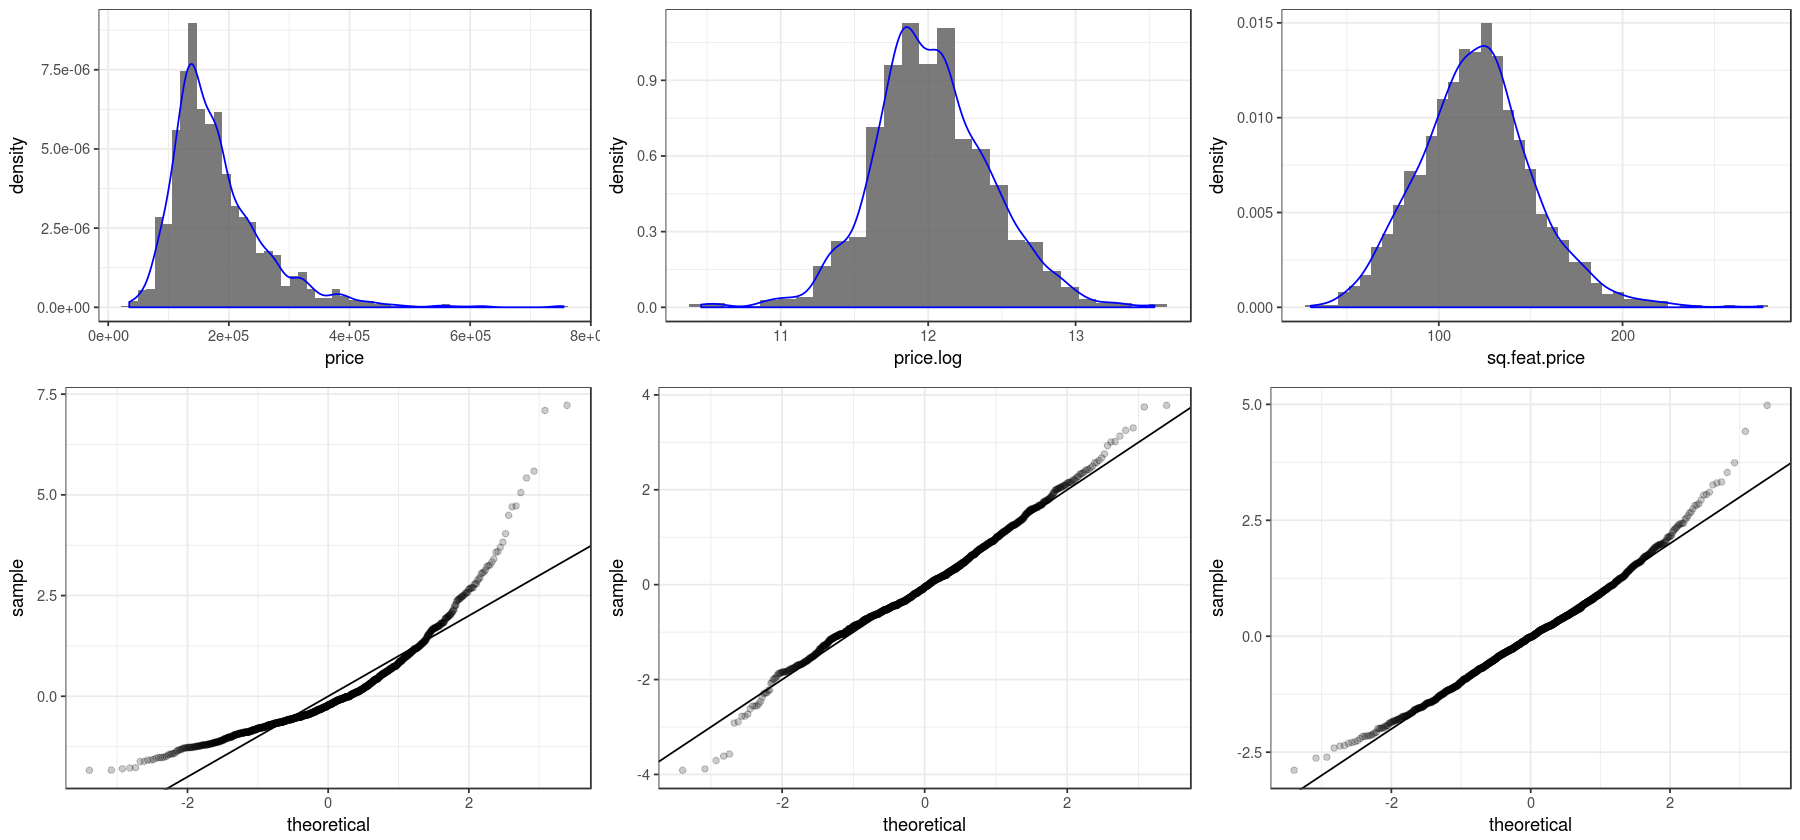

In [5]:
p1 <- trainset %>% 
    ggplot(aes(price)) +
    geom_histogram(aes(y=..density..), binwidth=14e3, alpha=0.8) +
    geom_density(color="blue") +
    theme_bw()

p2 <- trainset %>% 
    ggplot(aes(price.log)) +
    geom_histogram(aes(y=..density..), binwidth=0.12, alpha=0.8) +
    geom_density(color="blue") +
    theme_bw()

p3 <- trainset %>% 
    ggplot(aes(sq.feat.price)) +
    geom_histogram(aes(y=..density..), binwidth=6, alpha=0.8) +
    geom_density(color="blue") +
    theme_bw()

qq1 <- trainset %>% 
    mutate(price.norm = (price - mean(price)) / sd(price)) %>%
    ggplot() +
    geom_qq(aes(sample=price.norm), alpha=0.2) +
    geom_abline(slope=1) +
    theme_bw()

qq2 <- trainset %>% 
    mutate(
        price.log.norm = (price.log - mean(price.log)) / sd(price.log)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=price.log.norm), alpha=0.2) +
    geom_abline(slope=1) +
    theme_bw()

qq3 <- trainset %>% 
    mutate(
        sq.feat.price.norm = (sq.feat.price - mean(sq.feat.price)) / sd(sq.feat.price)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=sq.feat.price.norm), alpha=0.2) +
    geom_abline(slope=1) +
    theme_bw()

options(repr.plot.width = 15, repr.plot.height = 7)

grid.arrange(
    p1, p2, p3, qq1, qq2, qq3, 
    layout_matrix=rbind(c(1, 2, 3), c(4, 5, 6)),
    heights=c(45, 55))

### Single variable $R^2$

In [58]:
r2.target.vs.vars <- 
    trainset %>%
    gather(var.name, var.value, -price, -price.log, -sq.feat.price) %>%
    group_by(var.name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(price ~ var.value, .)),
        glance = map(mod, broom::glance),
        r2 = map_dbl(glance, 'r.squared'),
        
        mod.log = map(data, ~lm(price.log ~ var.value, .)),
        glance.log = map(mod.log, broom::glance),
        r2.log = map_dbl(glance.log, 'r.squared'),
        
        mod.sq.feat = map(data, ~lm(sq.feat.price ~ var.value, .)),
        glance.sq.feat = map(mod.sq.feat, broom::glance),
        r2.sq.feat = map_dbl(glance.sq.feat, 'r.squared')
    ) %>%
    select(var.name, r2, r2.log, r2.sq.feat) %>%
    mutate_if(is.numeric, funs(round(., 3)))

r2.target.vs.vars %>% arrange(desc(r2)) %>% head(12) %>% t
r2.target.vs.vars %>% arrange(desc(r2.log)) %>% head(12) %>% t
r2.target.vs.vars %>% arrange(desc(r2.sq.feat)) %>% head(12) %>% t

[,1]        [,2]    [,3]      [,4]         [,5]     [,6]     
var.name   OverallQual quality GrLivArea Neighborhood log.area ExterQual
r2         0.633       0.621   0.540     0.523        0.494    0.471    
r2.log     0.675       0.657   0.526     0.572        0.544    0.466    
r2.sq.feat 0.240       0.234   0.007     0.292        0.011    0.250    
           [,7]     [,8]        [,9]        [,10]      [,11]     [,12]     
var.name   BsmtQual KitchenQual TotalBsmtSF GarageCars X1stFlrSF GarageArea
r2         0.454    0.446       0.424       0.411      0.399     0.396     
r2.log     0.455    0.451       0.419       0.464      0.385     0.431     
r2.sq.feat 0.302    0.244       0.229       0.166      0.093     0.170

[,1]        [,2]    [,3]         [,4]     [,5]      [,6]     
var.name   OverallQual quality Neighborhood log.area GrLivArea ExterQual
r2         0.633       0.621   0.523        0.494    0.540     0.471    
r2.log     0.675       0.657   0.572        0.544    0.526     0.466    
r2.sq.feat 0.240       0.234   0.292        0.011    0.007     0.250    
           [,7]       [,8]     [,9]        [,10]      [,11]       [,12]    
var.name   GarageCars BsmtQual KitchenQual GarageArea TotalBsmtSF X1stFlrSF
r2         0.411      0.454    0.446       0.396      0.424       0.399    
r2.log     0.464      0.455    0.451       0.431      0.419       0.385    
r2.sq.feat 0.166      0.302    0.244       0.170      0.229       0.093

[,1]      [,2]     [,3]         [,4]      [,5]        [,6]       
var.name   YearBuilt BsmtQual Neighborhood ExterQual KitchenQual OverallQual
r2         0.274     0.454    0.523        0.471     0.446       0.633      
r2.log     0.345     0.455    0.572        0.466     0.451       0.675      
r2.sq.feat 0.317     0.302    0.292        0.250     0.244       0.240      
           [,7]    [,8]        [,9]         [,10]        [,11]      [,12]     
var.name   quality TotalBsmtSF BsmtFinType1 YearRemodAdd BsmtFinSF1 Foundation
r2         0.621   0.424       0.209        0.258        0.168      0.255     
r2.log     0.657   0.419       0.228        0.320        0.154      0.304     
r2.sq.feat 0.234   0.229       0.214        0.208        0.201      0.187

### Quality

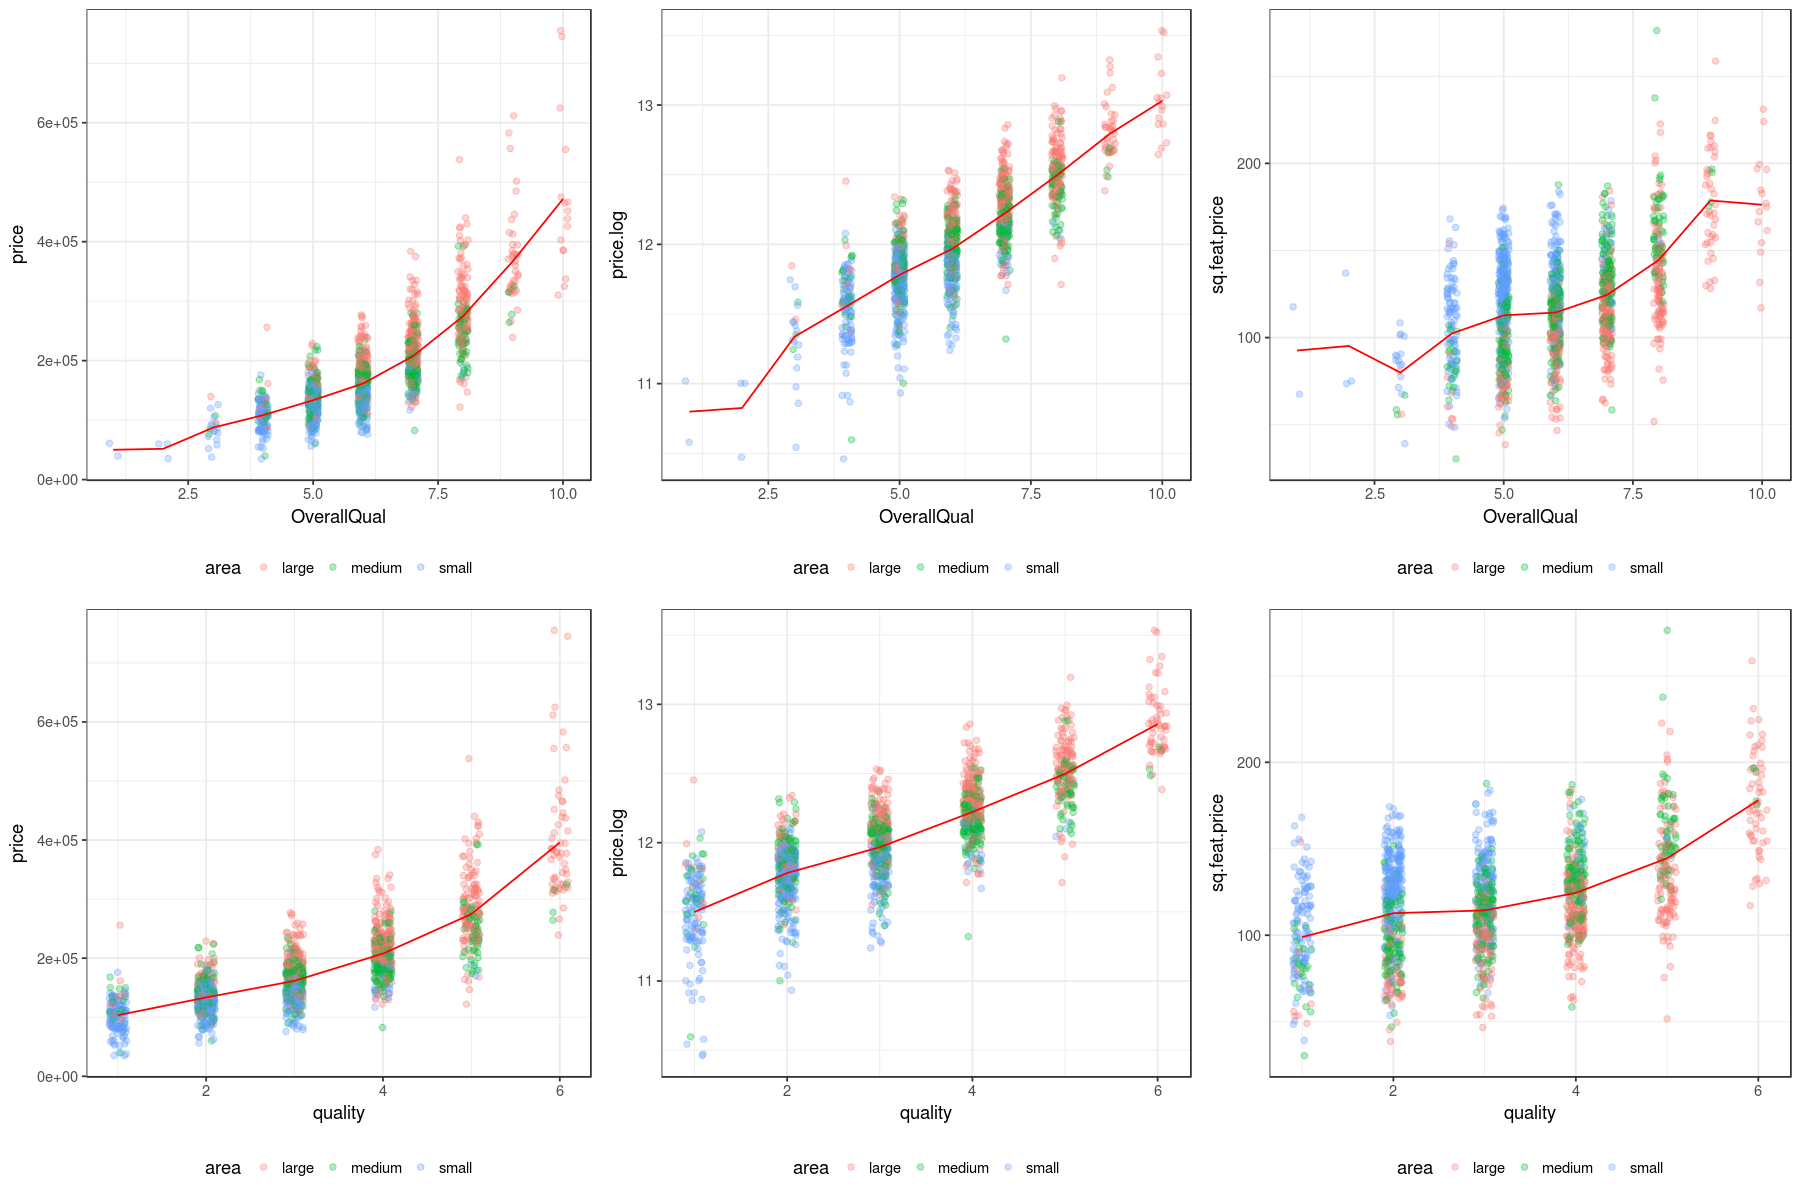

In [43]:
df <- 
    trainset %>%
    mutate(
        area = case_when(
            GrLivArea <= quantile(GrLivArea, 0.33) ~ 'small',
            GrLivArea > quantile(GrLivArea, 0.33)  & 
                GrLivArea < quantile(GrLivArea, 0.66)~ 'medium',
            TRUE ~ 'large'
        )
    )

p1 <- 
    df %>%
    ggplot(aes(x=OverallQual, y=price)) +
    geom_jitter(aes(color=area), alpha=0.3, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

p2 <- 
    df %>%
    ggplot(aes(x=OverallQual, y=price.log)) +
    geom_jitter(aes(color=area), alpha=0.3, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

p3 <-
    df %>%
    ggplot(aes(x=OverallQual, y=sq.feat.price)) +
    geom_jitter(aes(color=area), alpha=0.3, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

grob1 <- arrangeGrob(p1, p2, p3, layout_matrix=rbind(c(1, 2, 3)))

p1 <- 
    df %>%
    ggplot(aes(x=quality, y=price)) +
    geom_jitter(aes(color=area), alpha=0.3, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

p2 <- 
    df %>%
    ggplot(aes(x=quality, y=price.log)) +
    geom_jitter(aes(color=area), alpha=0.3, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

p3 <-
    df %>%
    ggplot(aes(x=quality, y=sq.feat.price)) +
    geom_jitter(aes(color=area), alpha=0.3, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

grob2 <- arrangeGrob(p1, p2, p3, layout_matrix=rbind(c(1, 2, 3)))

options(repr.plot.width = 15, repr.plot.height = 10)
arrangeGrob(grob1, grob2) %>% grid.draw

### price.log ~ quality

[[1]]
  r.squared adj.r.squared     sigma statistic p.value df   logLik       AIC
1 0.6565905     0.6563546 0.2343183  2783.836       0  2 47.85559 -89.71117
        BIC deviance df.residual
1 -73.85671 79.94176        1456

[[2]]
  r.squared adj.r.squared     sigma statistic p.value df   logLik       AIC
1 0.6600165     0.6595491 0.2332266  1412.309       0  3 55.16486 -102.3297
        BIC deviance df.residual
1 -81.19043 79.14423        1455

[[3]]
  r.squared adj.r.squared     sigma statistic p.value df   logLik       AIC
1 0.6621931     0.6617288 0.2324788  1426.097       0  3 59.84706 -111.6941
        BIC deviance df.residual
1 -90.55484 78.63753        1455

[[1]]
         term   estimate   std.error statistic p.value
1 (Intercept) 11.2511479 0.015881523 708.44261       0
2     quality  0.2489134 0.004717658  52.76207       0

[[2]]
         term   estimate   std.error  statistic      p.value
1 (Intercept) 11.3630041 0.033215016 342.104430 0.000000e+00
2     quality  0.1682582 0.021580926   7.796615 1.203635e-14
3    quality2  0.0122278 0.003193405   3.829078 1.340868e-04

[[3]]
         term   estimate   std.error  statistic       p.value
1 (Intercept) 11.1163011 0.031651234 351.212246  0.000000e+00
2     quality  0.2799650 0.007865384  35.594574 3.898720e-200
3 quality.low  0.1041564 0.021202804   4.912386  1.001421e-06

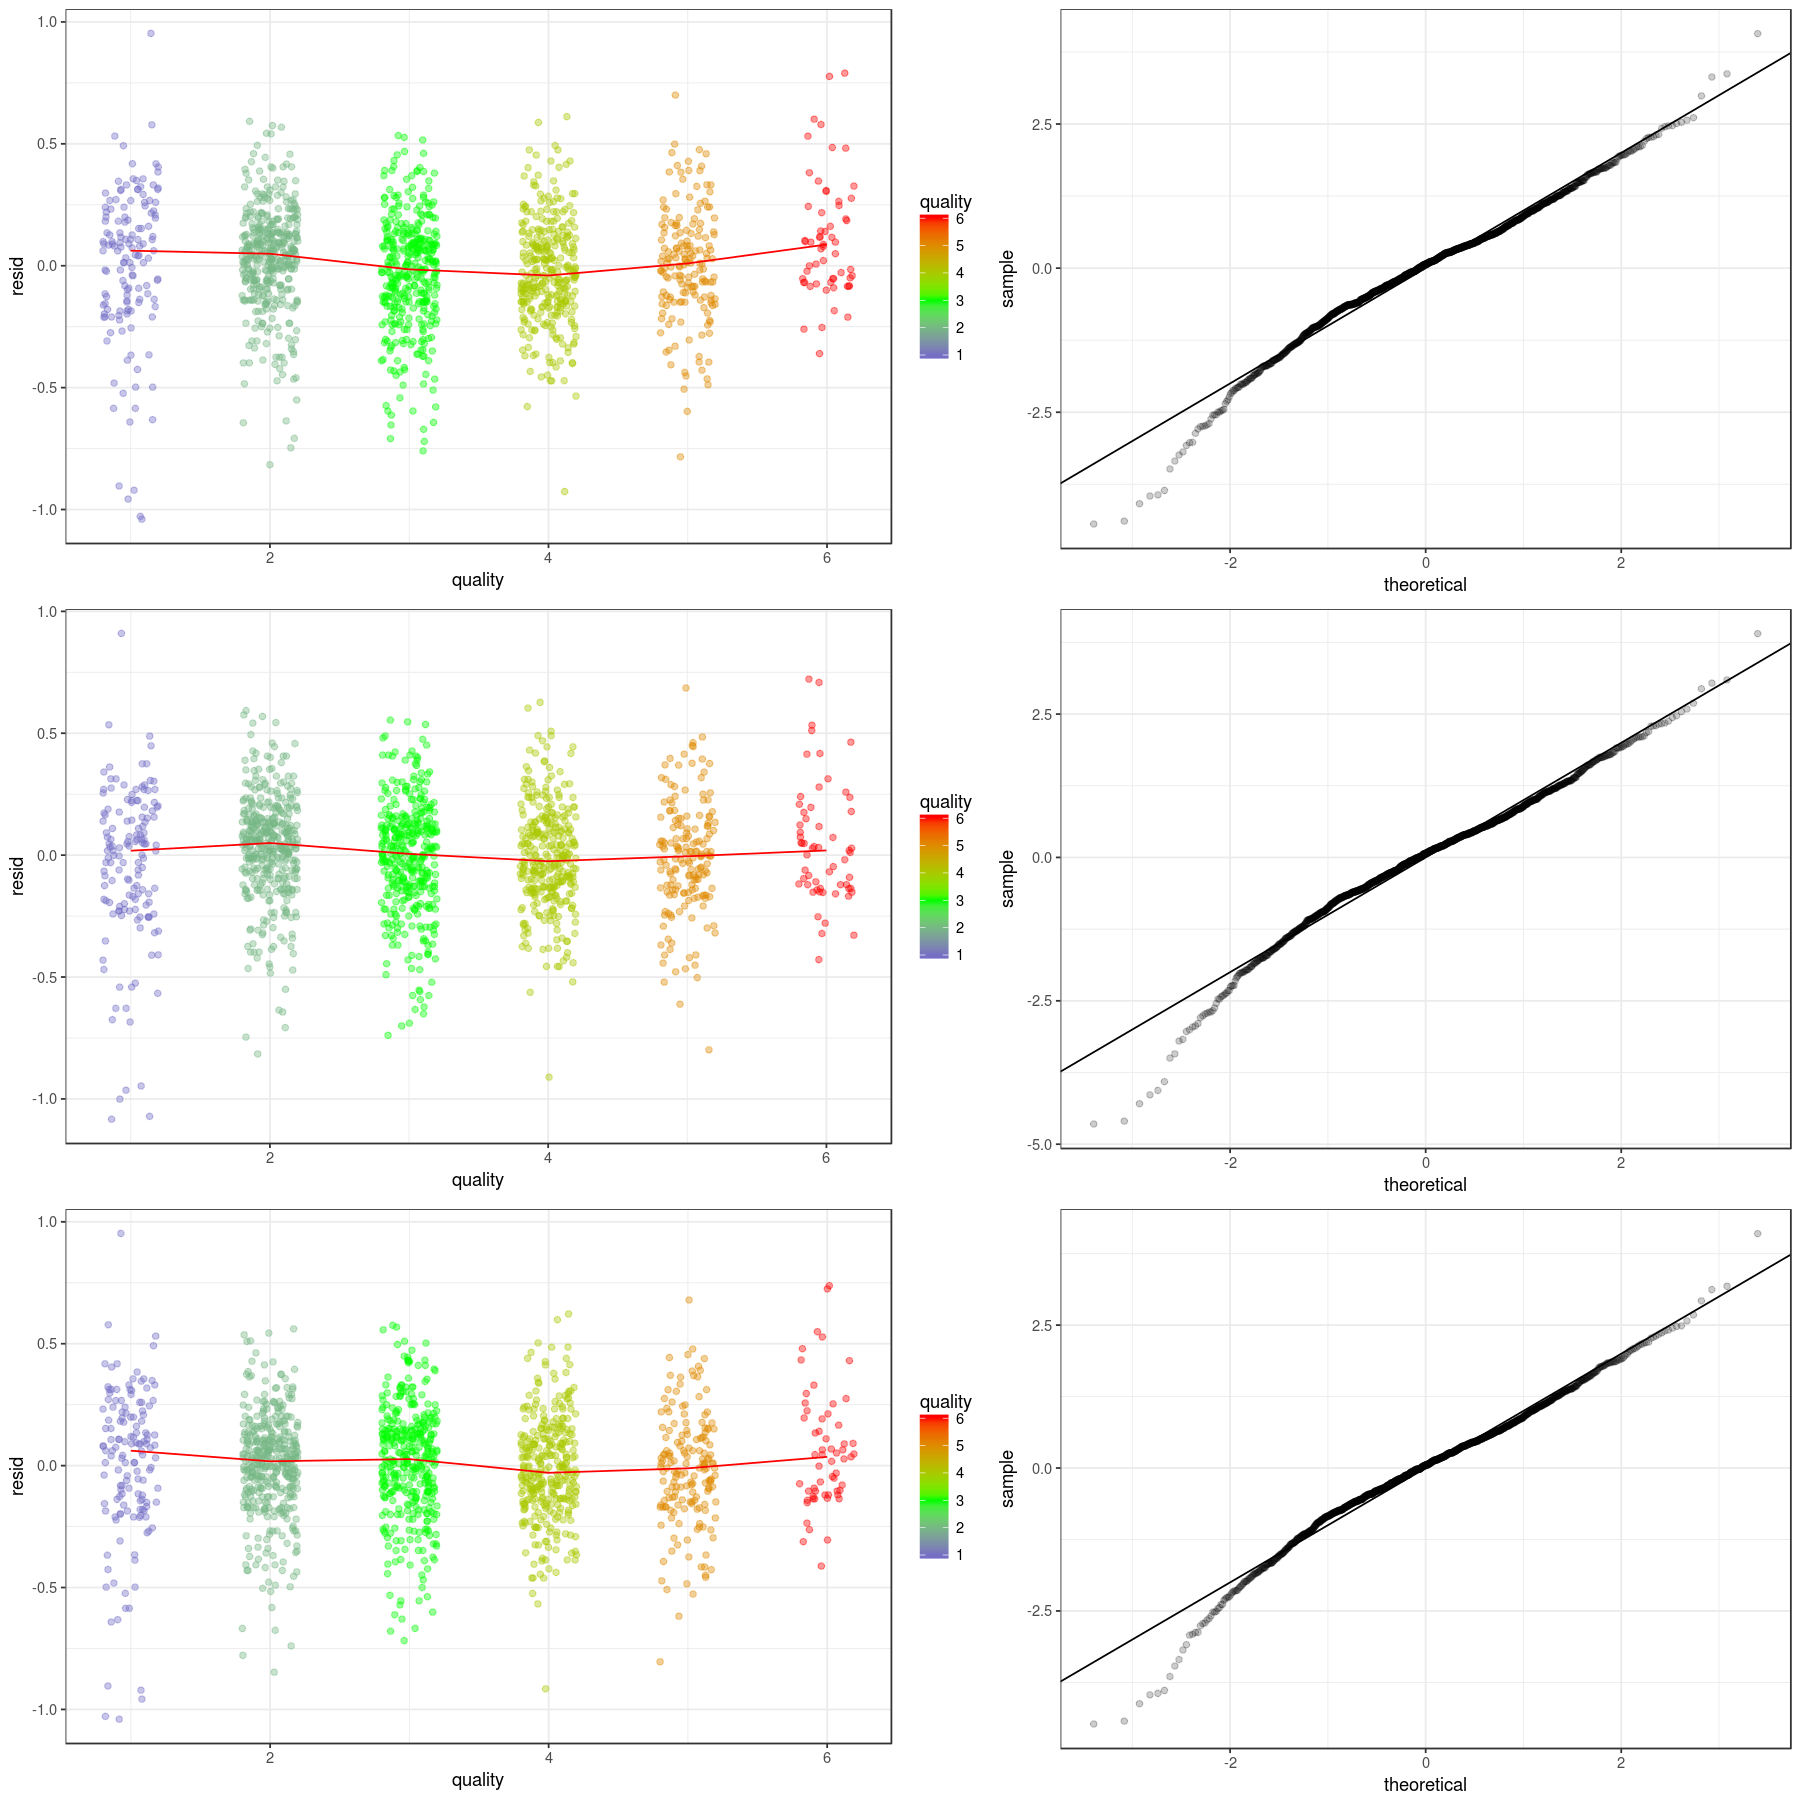

In [55]:
mods <- list()

mods[[1]] <- lm(price.log ~ quality, data=trainset)

mods[[2]] <- lm(price.log ~ quality + quality2, 
                data=trainset %>% mutate(quality2 = quality^2))
# the best
mods[[3]] <- lm(price.log ~ quality + quality.low, 
                data=trainset %>% mutate(quality.low = ifelse(quality <= 2, 1, 0)))

mods %>% map(glance)
mods %>% map(tidy)

grobs <- 
    mods %>% 
    map(function (model) {
        df <- 
            model %>% 
            augment %>% 
            select(price.log, quality, resid=.resid)
        
        p <- 
            df %>%
            ggplot(aes(x=quality, y=resid)) +
            geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
            scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
            stat_summary(fun.y = median, geom="line", colour = "red") +
            theme_bw()

        qq <-
            df %>% 
            mutate(resid.norm = (resid - mean(resid)) / sd(resid)) %>%
            ggplot() +
            geom_qq(aes(sample=resid.norm), alpha=0.2) +
            geom_abline(slope=1) +
            theme_bw()

        grob <- arrangeGrob(p, qq, layout_matrix=rbind(c(1, 2)), widths=c(55, 45))
    })

      
options(repr.plot.width = 15, repr.plot.height = 15)
arrangeGrob(grobs=grobs) %>% grid.draw

In [60]:
trainset %>% 
    select(-OverallQual, -quality, -price, -price.log, -sq.feat.price) %>% 
    cor(trainset$quality) %>% 
    as.data.frame %>% 
    rownames_to_column('var.name') %>%
    rename(corr.to.quality=V1) %>%
    left_join(r2.target.vs.vars, by='var.name') %>%
    mutate(
       max.r2 = pmax(r2, r2.log, r2.sq.feat),
       `max.r2/corr` = r2.log/corr.to.quality,
    ) %>%
    arrange(desc(abs(`max.r2/corr`))) %>%
    mutate_if(is.numeric, funs(round(., 3))) %>%
    head(10)

var.name     corr.to.quality r2    r2.log r2.sq.feat max.r2 max.r2/corr
1  log.area     0.601           0.494 0.544  0.011      0.544  0.905      
2  GrLivArea    0.584           0.540 0.526  0.007      0.540  0.901      
3  X1stFlrSF    0.463           0.399 0.385  0.093      0.399  0.831      
4  Neighborhood 0.701           0.523 0.572  0.292      0.572  0.816      
5  TotalBsmtSF  0.528           0.424 0.419  0.229      0.424  0.793      
6  GarageArea   0.556           0.396 0.431  0.170      0.431  0.776      
7  LotArea      0.088           0.072 0.068  0.013      0.072  0.773      
8  GarageCars   0.602           0.411 0.464  0.166      0.464  0.771      
9  BsmtFinSF1   0.210           0.168 0.154  0.201      0.201  0.732      
10 TotRmsAbvGrd 0.415           0.289 0.289  0.031      0.289  0.697

### Area

r.squared adj.r.squared sigma     statistic p.value       df logLik   
1 0.525931  0.5256054     0.2753092 1615.283  2.966447e-238 2  -187.1954
  AIC      BIC      deviance df.residual
1 380.3908 396.2453 110.3578 1456

r.squared adj.r.squared sigma     statistic p.value       df logLik   
1 0.5437991 0.5434858     0.2700711 1735.576  2.079661e-250 2  -159.1875
  AIC      BIC      deviance df.residual
1 324.3749 340.2294 106.1983 1456

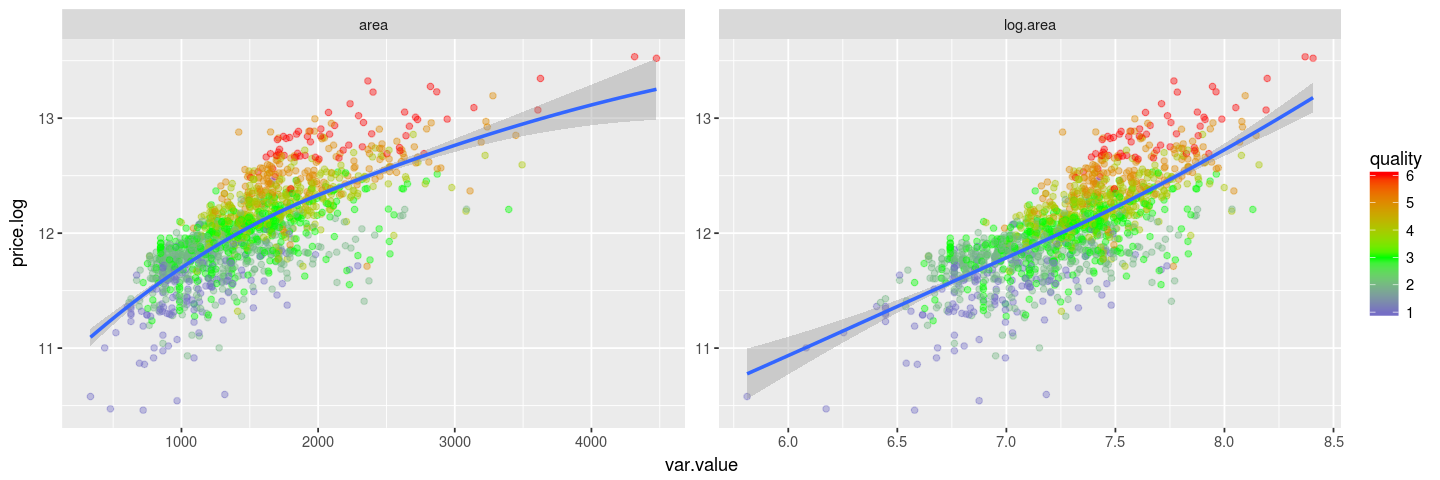

In [80]:
options(repr.plot.width = 12, repr.plot.height = 4)

lm(price.log ~ GrLivArea, data=trainset) %>% glance
lm(price.log ~ log.area, data=trainset) %>% glance

trainset %>% 
    rename(area=GrLivArea) %>%
    select(area, log.area, price.log, quality) %>%
    gather(var.name, var.value, -price.log, -quality) %>% 
    ggplot(aes(x=var.value, y=price.log)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~var.name, ncol=2, scales="free")

r.squared adj.r.squared sigma     statistic p.value       df logLik   
1 0.5437991 0.5434858     0.2700711 1735.576  2.079661e-250 2  -159.1875
  AIC      BIC      deviance df.residual
1 324.3749 340.2294 106.1983 1456

term        estimate  std.error  statistic p.value      
1 (Intercept) 5.5415392 0.15576391 35.57653  5.072263e-200
2 log.area    0.8921619 0.02141518 41.66025  2.079661e-250

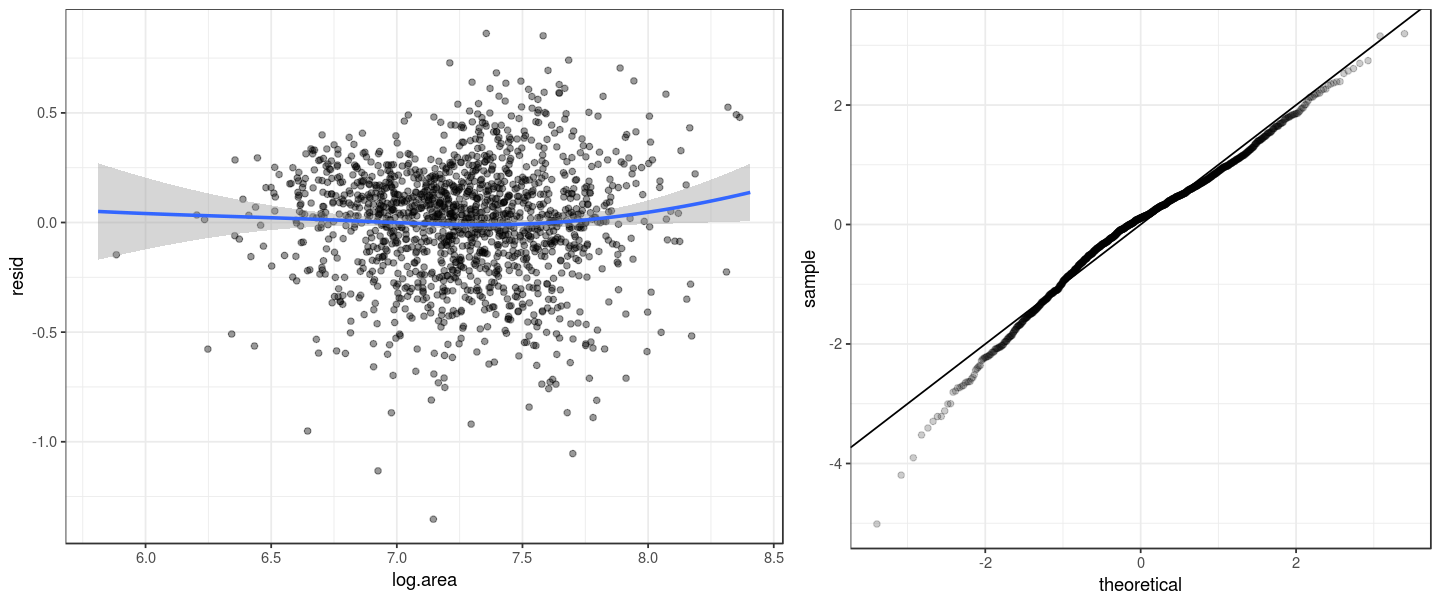

In [81]:
options(repr.plot.width = 12, repr.plot.height = 5)

mod <- lm(price.log ~ log.area, data=trainset)
mod %>% glance
mod %>% tidy

mod %>% 
    augment %>% 
    select(price.log, log.area, resid=.resid) %>%
    (function (df) {
        p <- 
            df %>%
            ggplot(aes(x=log.area, y=resid)) +
            geom_jitter(alpha=0.4, width=0.2, height=0) +
            geom_smooth(method = "loess", span = 1) +
            theme_bw()

        qq <-
            df %>% 
            mutate(resid.norm = (resid - mean(resid)) / sd(resid)) %>%
            ggplot() +
            geom_qq(aes(sample=resid.norm), alpha=0.2) +
            geom_abline(slope=1) +
            theme_bw()
        
        arrangeGrob(p, qq, layout_matrix=rbind(c(1, 2)), widths=c(55, 45))
    }) %>% grid.draw

In [86]:
X <- trainset %>%
    select(-GrLivArea, -log.area, -OverallQual, -quality, -price, -price.log, -sq.feat.price) %>%
    cor(trainset %>% select(quality, log.area)) %>% 
    as.data.frame %>% 
    rownames_to_column('var.name') %>% 
    left_join(r2.target.vs.vars, by='var.name') %>%
    mutate(
       max.r2 = pmax(r2, r2.log, r2.sq.feat),
       max.corr = pmax(log.area %>% abs, quality %>% abs),
       max.r2/max.corr
    ) %>%
    mutate_if(is.numeric, funs(round(., 3))) 

X %>% arrange(desc(`max.r2/max.corr`)) %>% head(10)

var.name     quality log.area r2    r2.log r2.sq.feat max.r2 max.corr
1  BsmtFullBath 0.101   0.010    0.052 0.056  0.125      0.125  0.101   
2  BsmtFinSF1   0.210   0.130    0.168 0.154  0.201      0.201  0.210   
3  Neighborhood 0.701   0.478    0.523 0.572  0.292      0.572  0.701   
4  TotalBsmtSF  0.528   0.419    0.424 0.419  0.229      0.424  0.528   
5  GarageArea   0.556   0.467    0.396 0.431  0.170      0.431  0.556   
6  GarageCars   0.602   0.497    0.411 0.464  0.166      0.464  0.602   
7  X1stFlrSF    0.463   0.539    0.399 0.385  0.093      0.399  0.539   
8  MSSubClass   0.482   0.458    0.243 0.331  0.068      0.331  0.482   
9  GarageType   0.495   0.382    0.246 0.335  0.131      0.335  0.495   
10 GarageFinish 0.567   0.387    0.301 0.382  0.183      0.382  0.567   
   max.r2/max.corr
1  1.237          
2  0.956          
3  0.816          
4  0.803          
5  0.776          
6  0.771          
7  0.740          
8  0.686          
9  0.676          
10 0.674

In [82]:
# trainset %>%
#     mutate(
#         price.level = case_when(
#             price.log <= quantile(price.log, 0.33) ~ 'low',
#             price.log > quantile(price.log, 0.33)  & 
#                 price.log < quantile(price.log, 0.66) ~ 'medium',
#             TRUE ~ 'high'
#         )
#     ) %>%
#     ggplot() +
#     geom_jitter(aes(x=quality, y=log.area, color=price.level), alpha=0.2, width=0.2, height=0) +
#     theme_bw()

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.754635  0.7542977     0.1981324 2237.47   0       3  292.9283 -577.8566
  BIC       deviance df.residual
1 -556.7173 57.11814 1455

term        estimate  std.error   statistic p.value      
1 (Intercept) 8.0310149 0.134221393 59.83409   0.000000e+00
2 log.area    0.4741085 0.019662604 24.11219  2.383194e-108
3 quality     0.1765286 0.004992495 35.35879  3.470013e-198

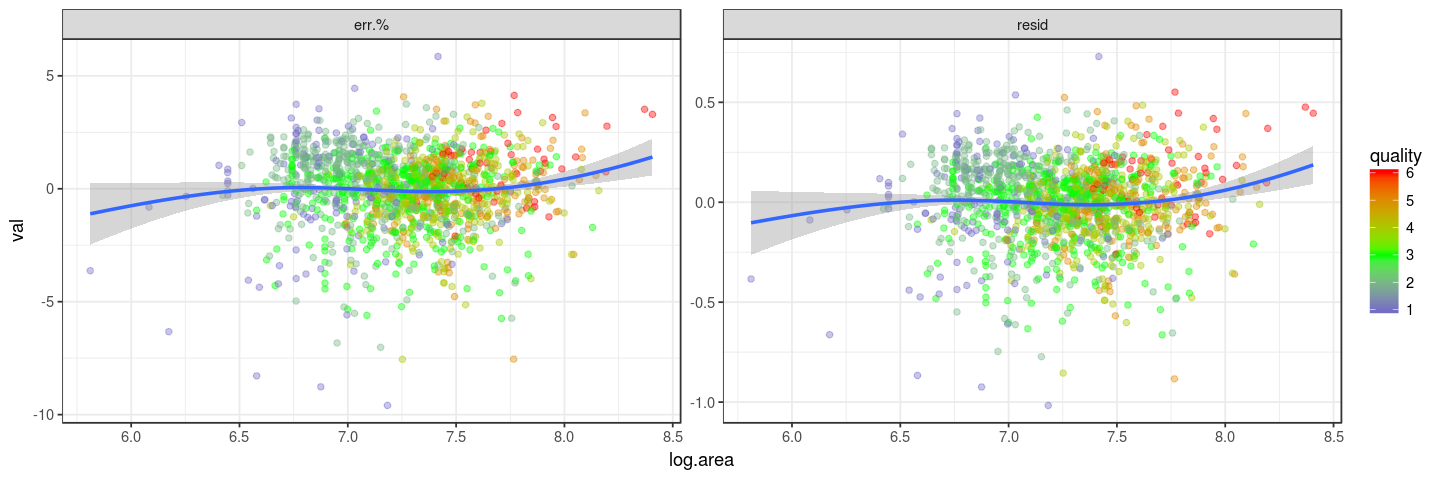

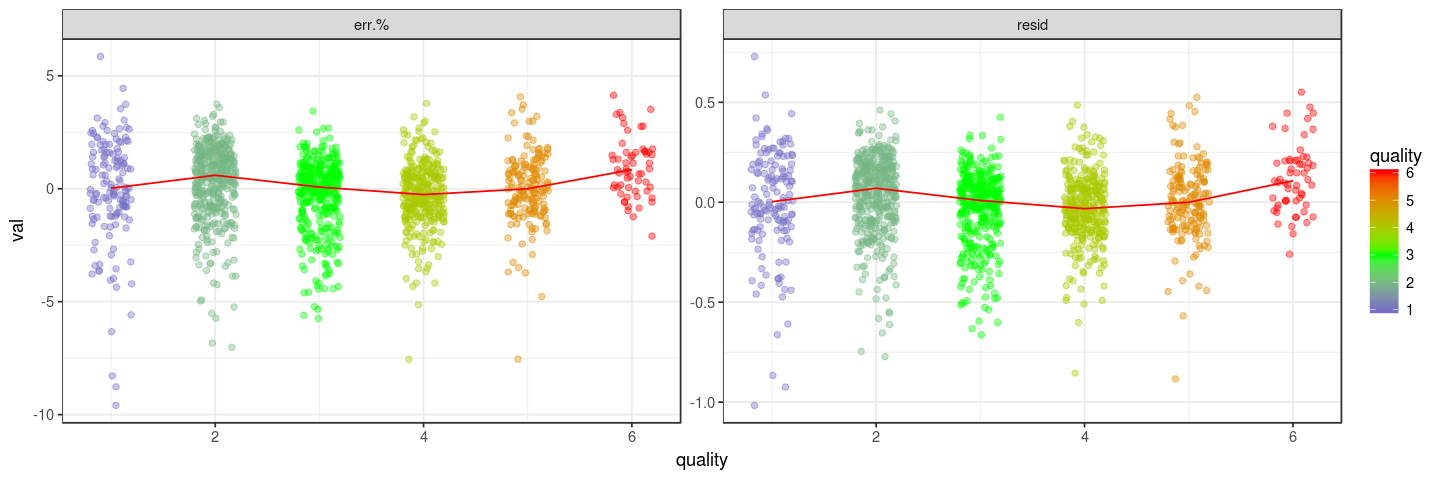

In [35]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(price.log ~ log.area + quality, data=trainset)

mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    select(price.log, log.area, quality, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / price.log) %>%
    gather(name, val, -price.log, -log.area, -quality)

df %>% 
    ggplot(aes(x=log.area, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=quality, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

r.squared adj.r.squared sigma    statistic p.value       df logLik    AIC    
1 0.3446195 0.3441694     0.323703 765.6103  9.084861e-136 2  -423.2915 852.583
  BIC      deviance df.residual
1 868.4375 152.565  1456

term        estimate    std.error    statistic p.value      
1 (Intercept) -3.29527359 0.5537139284 -5.95122   3.329151e-09
2 YearBuilt    0.00777148 0.0002808664 27.66966  9.084861e-136

r.squared adj.r.squared sigma   statistic p.value       df logLik   AIC    
1 0.4076478 0.4068335     0.30785 500.6544  3.564239e-166 3  -349.579 707.158
  BIC      deviance df.residual
1 728.2973 137.8927 1455

term        estimate      std.error    statistic p.value     
1 (Intercept)  3.862348e+02 3.131074e+01  12.33554 2.530705e-33
2 YearBuilt   -3.894084e-01 3.192224e-02 -12.19866 1.170740e-32
3 YearBuilt2   1.012188e-04 8.134896e-06  12.44254 7.570087e-34

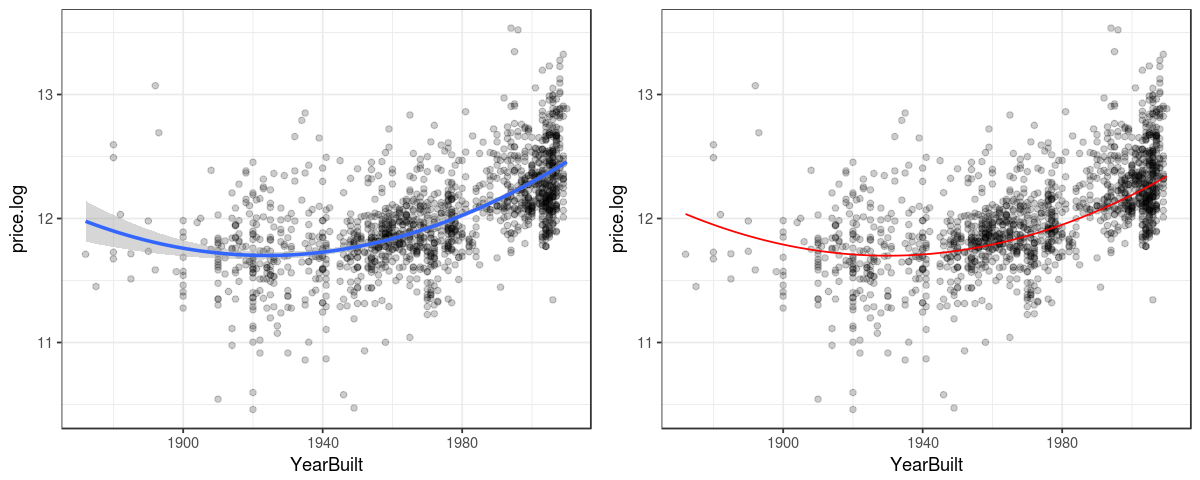

In [37]:
options(repr.plot.width = 10, repr.plot.height = 4)

mod1 <- lm(price.log ~ YearBuilt, data=trainset) 
mod1 %>% glance
mod1 %>% tidy

mod2 <- lm(price.log ~ YearBuilt + YearBuilt2, data=trainset %>% mutate(YearBuilt2 = YearBuilt^2))
mod2 %>% glance
mod2 %>% tidy

p1 <- 
    trainset %>%
    ggplot(aes(x=YearBuilt, y=price.log)) +
    geom_point(alpha=0.2) +
    geom_smooth(method = "loess", span = 1) +
    theme_bw()

p2 <-
    trainset %>%
    ggplot(aes(x=YearBuilt, y=price.log)) +
    geom_point(alpha=0.2) +
    stat_function(fun = function (x) { 11.7 + 0.0001*(x - 1930)^2 }, colour = "red") +
    theme_bw()

grid.arrange(p1, p2, layout_matrix=rbind(c(1, 2)))

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.7981759 0.7976203     0.1798185 1436.584  0       5  435.3388 -858.6775
  BIC       deviance df.residual
1 -826.9686 46.98232 1453

term        estimate      std.error    statistic p.value      
1 (Intercept) -7.355761e+01 2.072396e+01 -3.549399  3.984138e-04
2 log.area     5.327632e-01 1.815045e-02 29.352624 4.287568e-149
3 quality      1.310197e-01 5.938149e-03 22.064063  2.798099e-93
4 year         7.971236e-02 2.117362e-02  3.764702  1.733940e-04
5 year2       -1.950972e-05 5.410639e-06 -3.605807  3.217093e-04

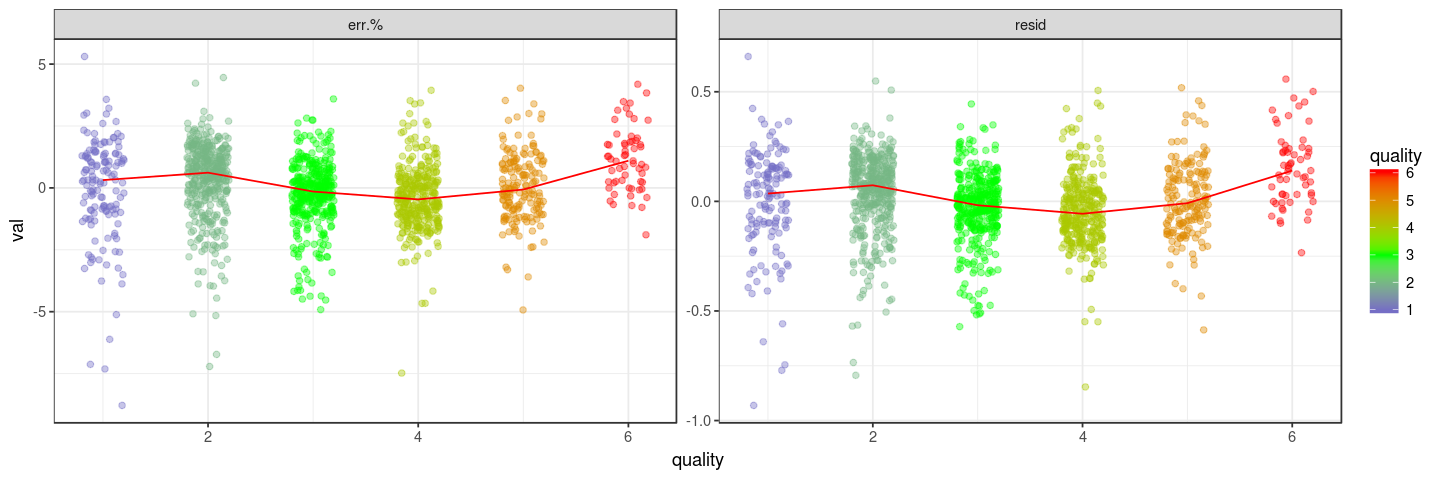

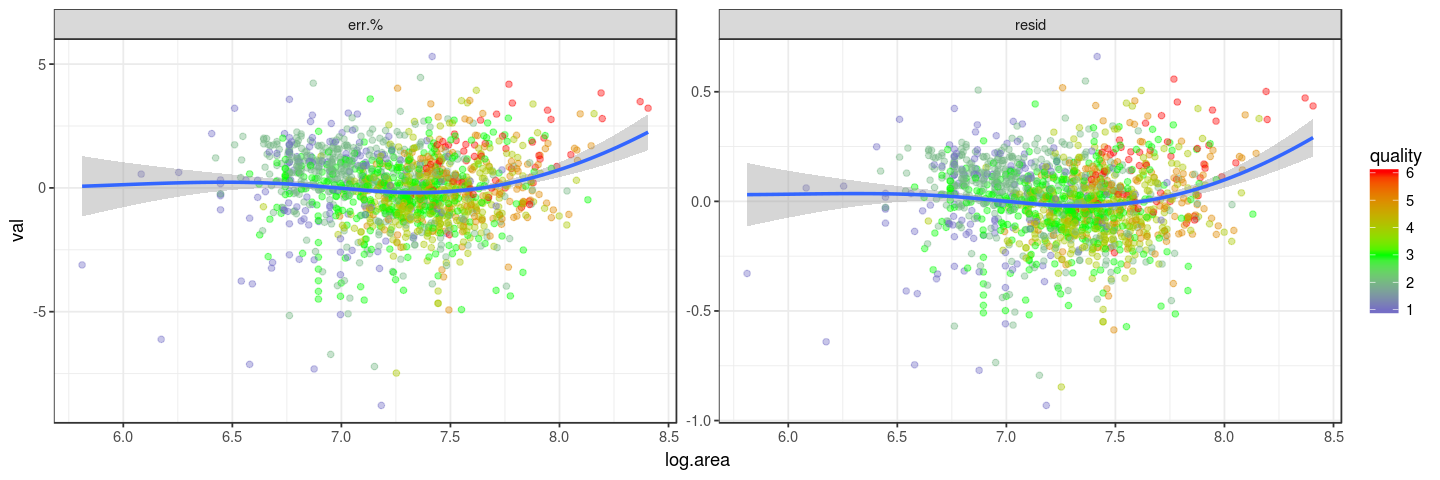

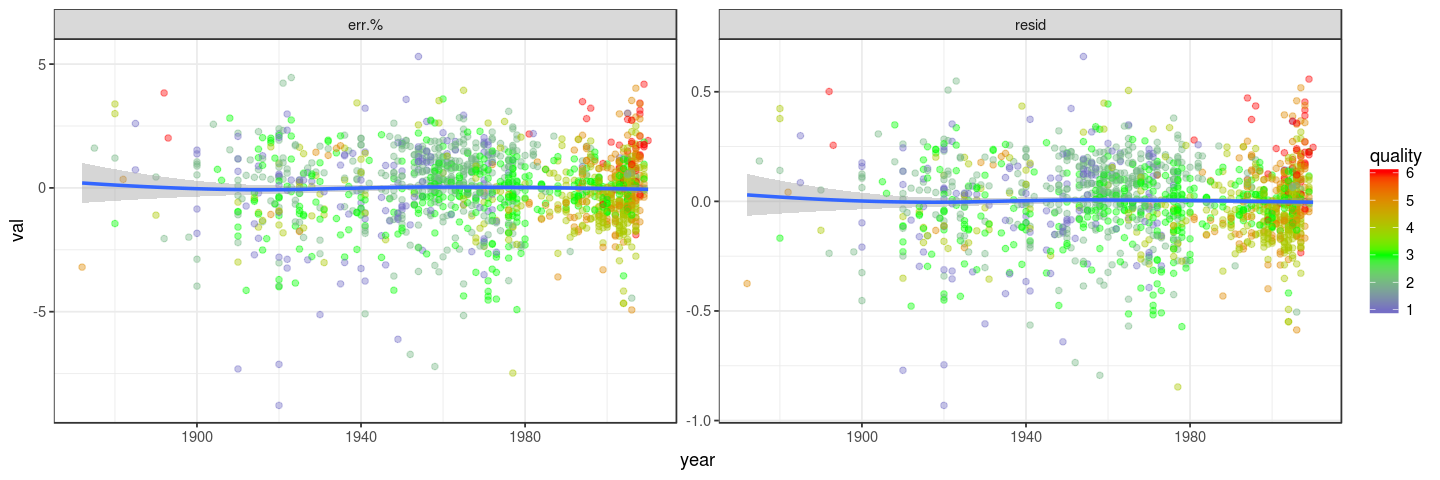

In [39]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(
    price.log ~ log.area + quality + year + year2, 
    data=trainset %>% 
         rename(year=YearBuilt) %>%
         mutate(year2 = year^2))

mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    select(log.area, quality, year, price.log, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / price.log) %>%
    gather(name, val, -price.log, -log.area, -quality, -year)

df %>% 
    ggplot(aes(x=quality, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=log.area, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=year, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

r.squared adj.r.squared sigma     statistic p.value       df logLik   
1 0.5718582 0.5715642     0.2616338 1944.743  1.726602e-270 2  -112.9113
  AIC      BIC      deviance df.residual
1 231.8226 247.6771 99.66645 1456

term         estimate std.error   statistic  p.value      
1 (Intercept)  12.02401 0.006851963 1754.82675  0.000000e+00
2 Neighborhood  1.00000 0.022676129   44.09924 1.726602e-270

mean(price.log)
1 12.02401

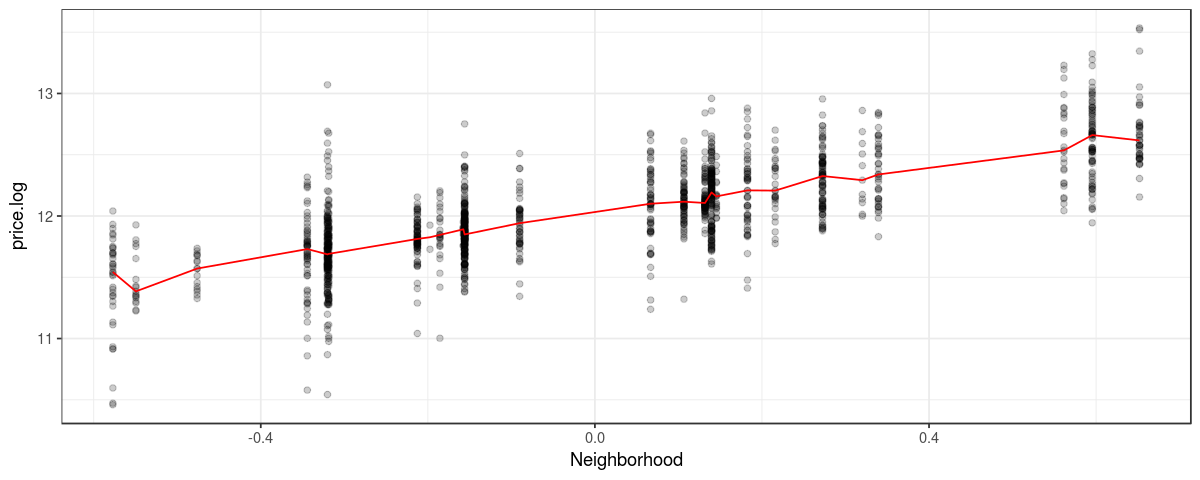

In [45]:
options(repr.plot.width = 10, repr.plot.height = 4)

mod <- lm(price.log ~ Neighborhood, data=trainset) 
mod %>% glance
mod %>% tidy

trainset %>% summarise(mean(price.log))

trainset %>%
    ggplot(aes(x=Neighborhood, y=price.log)) +
    geom_point(alpha=0.2) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    theme_bw()

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.8221211 0.8215086     0.1688727 1342.172  0       6  527.4069 -1040.814
  BIC      deviance df.residual
1 -1003.82 41.40814 1452

term        estimate      std.error    statistic p.value      
1 (Intercept) -8.819613e+01 1.949061e+01 -4.525056  6.530337e-06
2 log.area     4.817378e-01 1.743195e-02 27.635332 1.980469e-135
3 quality      1.063733e-01 5.848691e-03 18.187534  9.441095e-67
4 year         9.665210e-02 1.992163e-02  4.851615  1.356494e-06
5 year2       -2.421977e-05 5.092443e-06 -4.756022  2.170774e-06
6 hood         3.346765e-01 2.393837e-02 13.980758  9.150030e-42

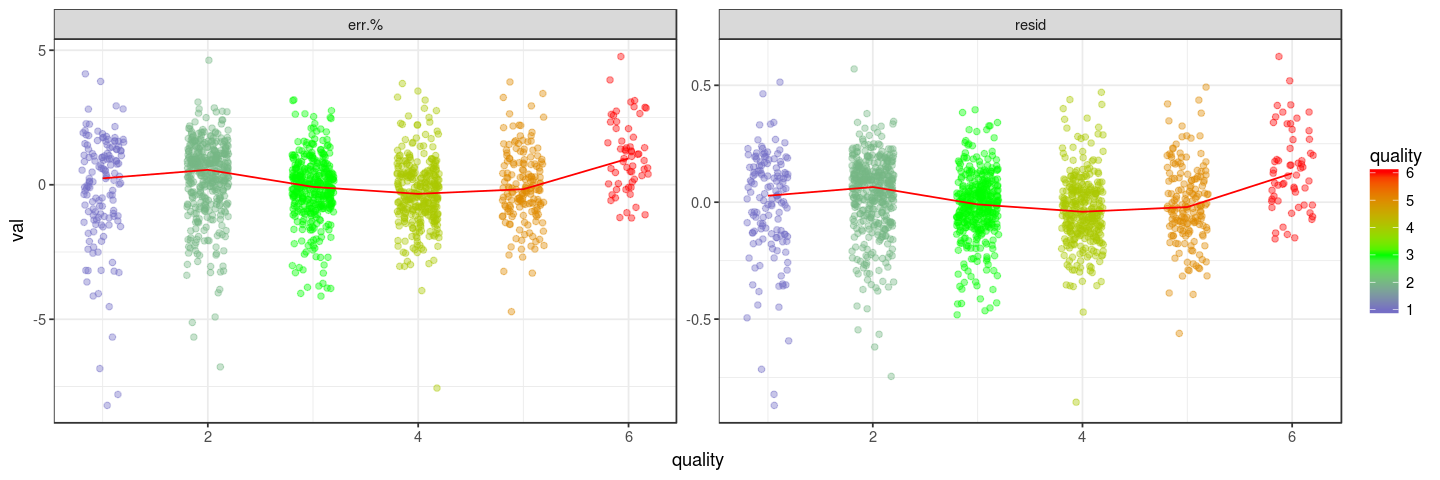

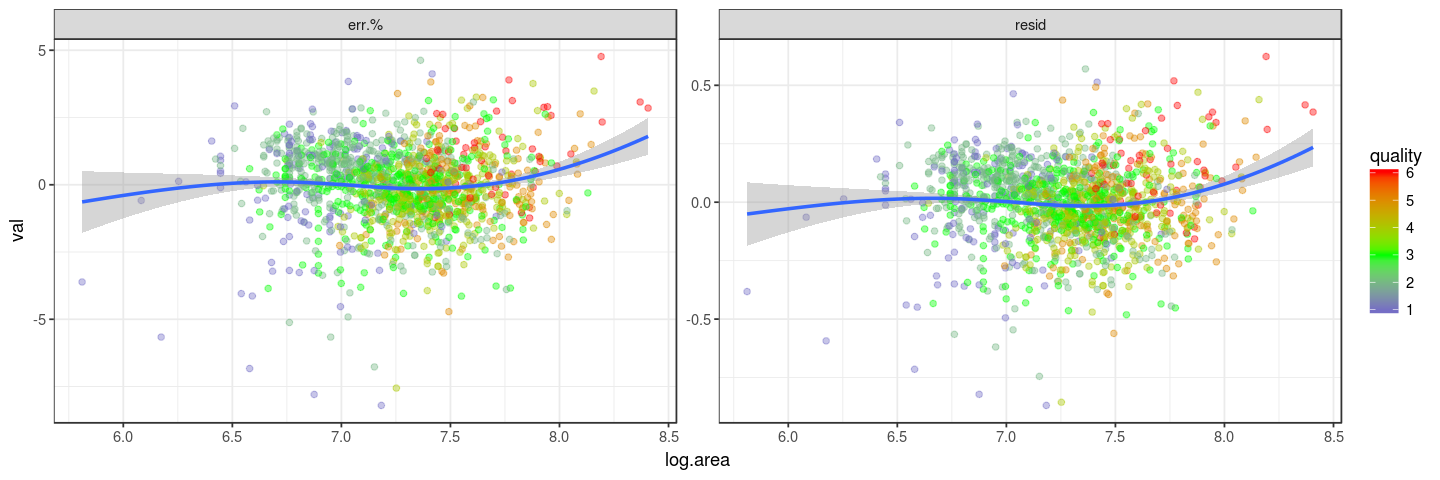

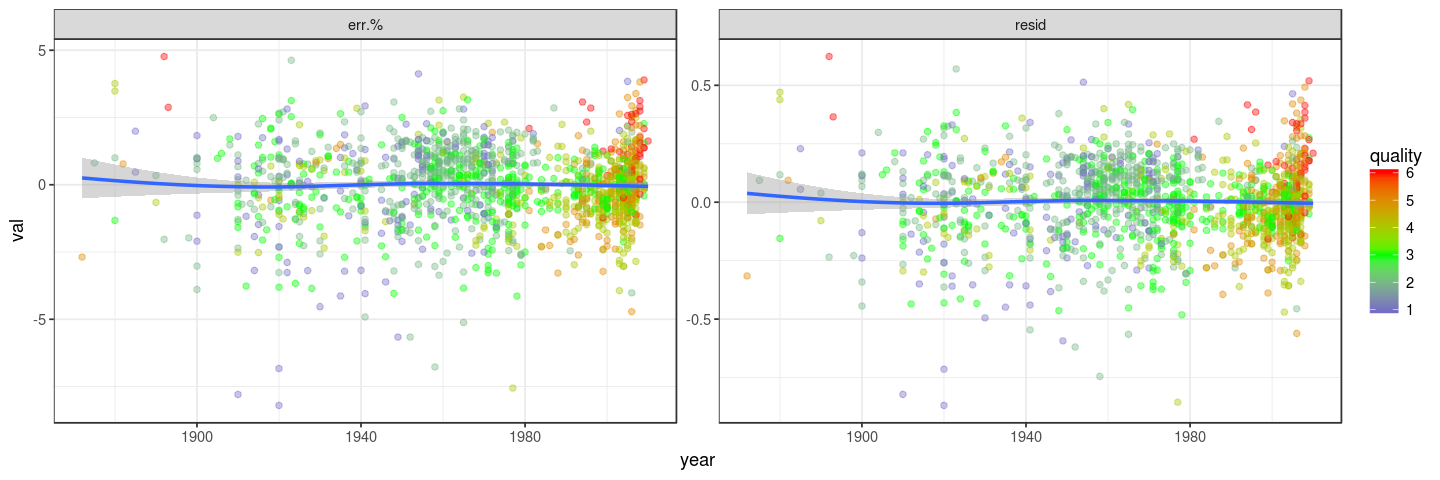

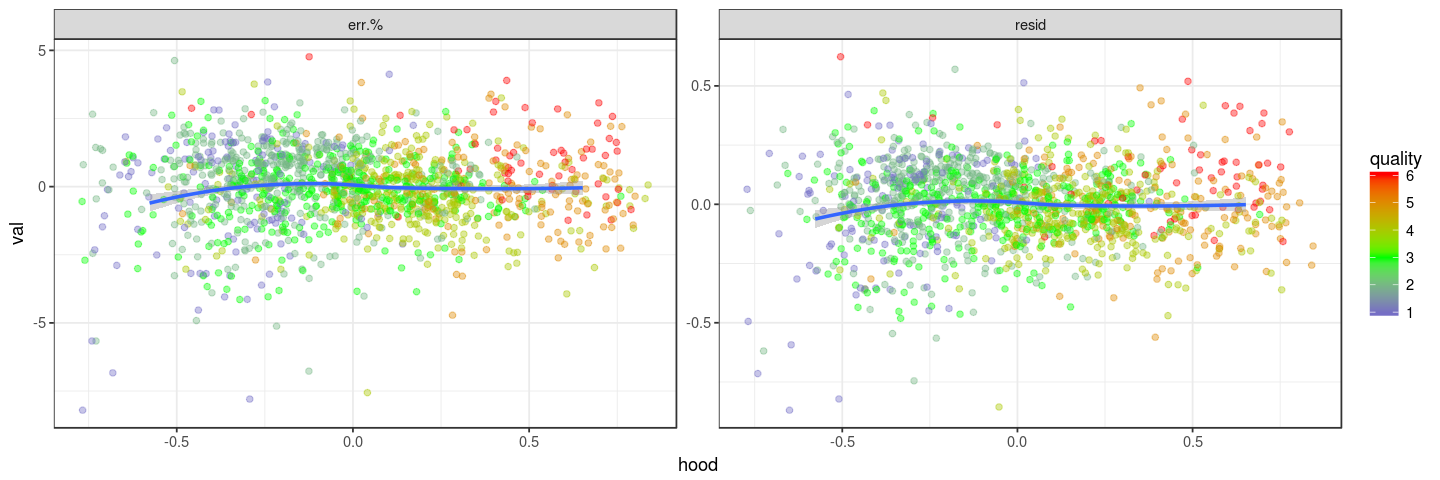

In [50]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(
        price.log ~ log.area + quality + year + year2 + hood, 
        data=trainset %>% 
             rename(year=YearBuilt, hood=Neighborhood) %>%
             mutate(year2 = year^2))

mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    select(log.area, quality, year, hood, price.log, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / price.log) %>%
    gather(name, val, -price.log, -log.area, -quality, -year, -hood)

df %>% 
    ggplot(aes(x=quality, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=log.area, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=year, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=hood, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.8269207 0.826205      0.1666363 1155.407  0       7  547.3472 -1078.694
  BIC       deviance df.residual
1 -1036.416 40.29086 1451

term        estimate      std.error    statistic p.value      
1 (Intercept) -9.285568e+01 1.924651e+01 -4.824546  1.551102e-06
2 log.area     4.884481e-01 1.723359e-02 28.342792 5.276353e-141
3 quality      1.366929e-01 7.493589e-03 18.241312  4.286005e-67
4 quality.low  9.761569e-02 1.538891e-02  6.343250  2.998806e-10
5 year         1.010947e-01 1.967027e-02  5.139463  3.130416e-07
6 year2       -2.532011e-05 5.027994e-06 -5.035828  5.354120e-07
7 hood         3.126350e-01 2.387555e-02 13.094354  4.117207e-37

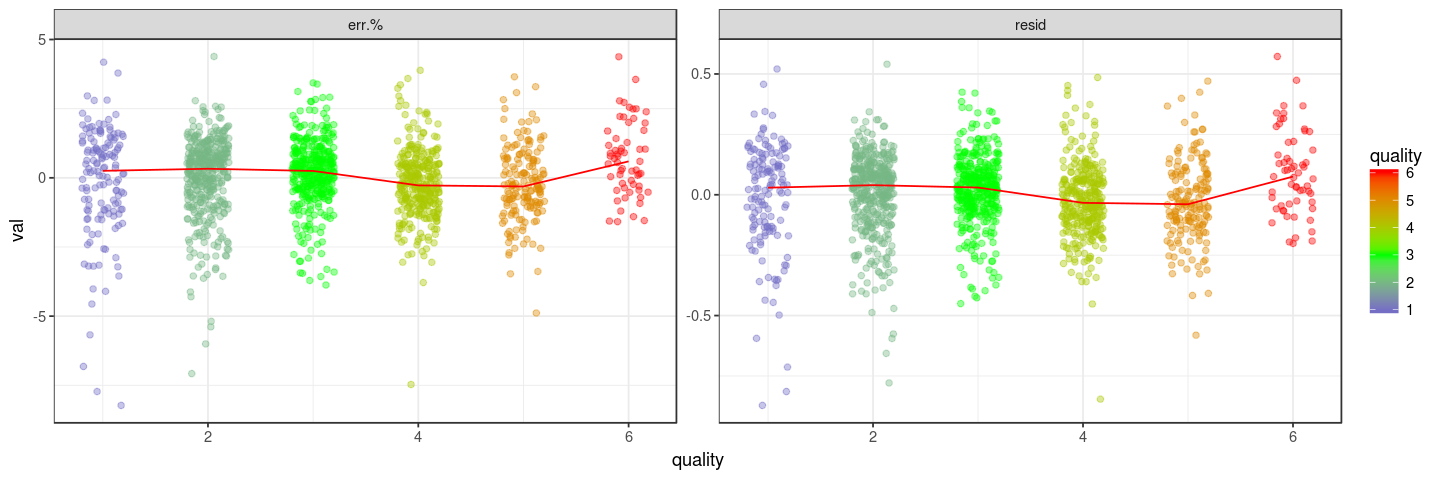

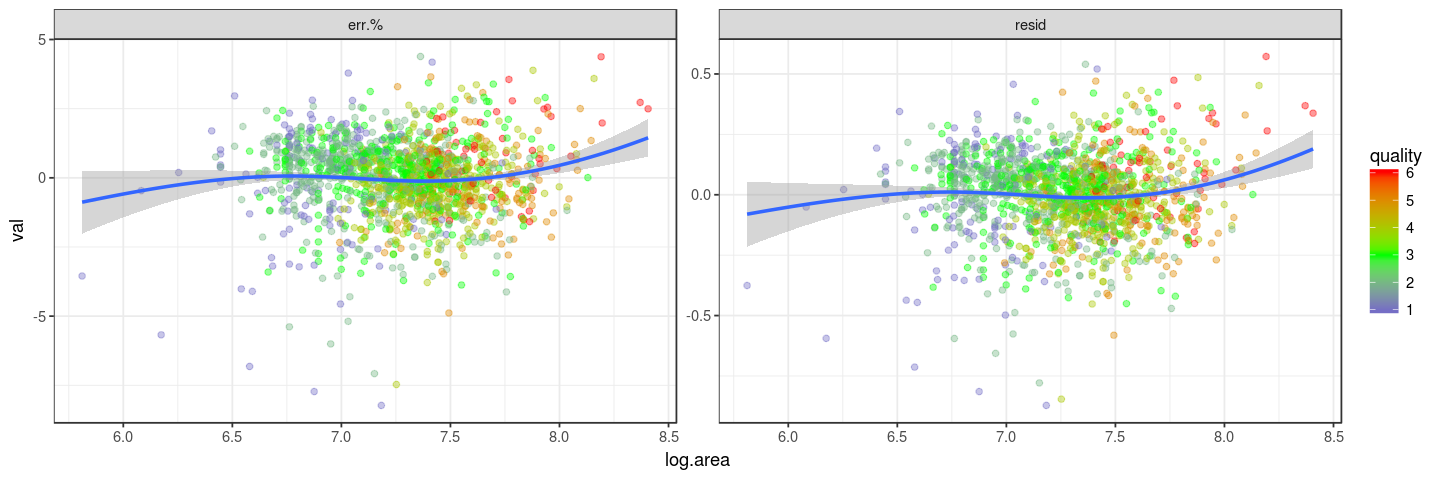

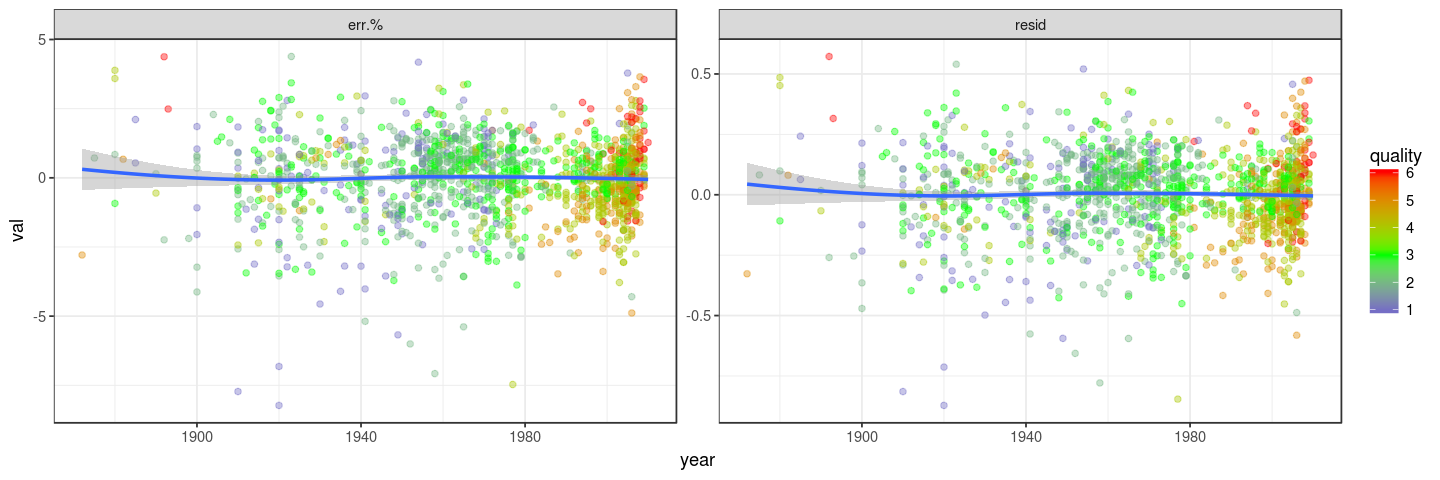

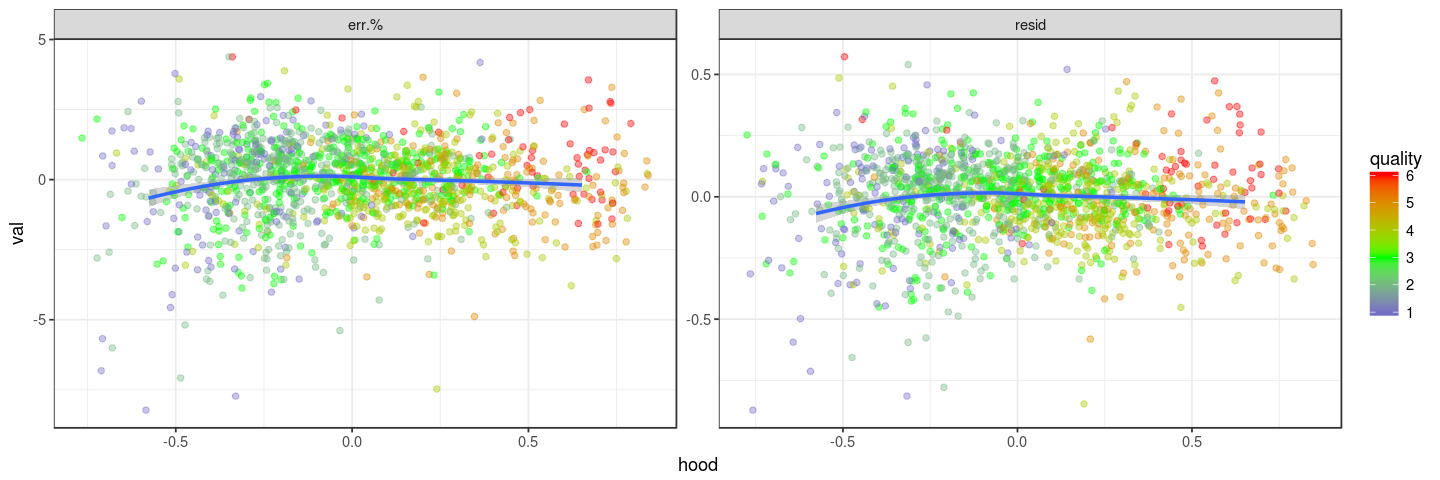

In [55]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(
        price.log ~ log.area + quality + quality.low + year + year2 + hood, 
        data=trainset %>% 
             rename(year=YearBuilt, hood=Neighborhood) %>%
             mutate(
                 year2 = year^2,
                 quality.low = ifelse(quality <= 2, 1, 0)
             ))

mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    select(log.area, quality, year, hood, price.log, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / price.log) %>%
    gather(name, val, -price.log, -log.area, -quality, -year, -hood)

df %>% 
    ggplot(aes(x=quality, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=log.area, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=year, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=hood, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

In [102]:
X <- trainset %>%
    select(-GrLivArea, -log.area, -OverallQual, -quality, -YearBuilt, -Neighborhood,
           -price, -price.log, -sq.feat.price) %>%
    cor(trainset %>% select(log.area, quality, YearBuilt, Neighborhood)) %>% 
    as.data.frame %>% 
    rownames_to_column('var.name') %>% 
    left_join(target.vs.vars, by='var.name') %>%
    filter(r2 > 0.1 | r2.log > 0.1 | r2.sq.feat > 0.1) %>%
    mutate(
        max.corr = pmax(log.area %>% abs, quality %>% abs, YearBuilt %>% abs, Neighborhood %>% abs),
        max.r2 = pmax(r2, r2.log, r2.sq.feat),
        max.r2/max.corr
    ) %>%
    mutate_if(is.numeric, funs(round(., 3)))

X %>% arrange(max.corr, desc(max.r2)) %>% head(10)

X %>% arrange(desc(`max.r2/max.corr`)) %>% head(10)

var.name      log.area quality YearBuilt Neighborhood r2    r2.log
1  BsmtFullBath  0.010    0.101   0.185     0.156        0.052 0.056 
2  WoodDeckSF    0.239    0.233   0.224     0.251        0.105 0.112 
3  GarageYrBlt   0.208    0.275   0.272     0.273        0.068 0.122 
4  BsmtFinSF1    0.130    0.210   0.250     0.277        0.168 0.154 
5  OpenPorchSF   0.305    0.295   0.184     0.215        0.103 0.106 
6  BsmtExposure  0.127    0.306   0.256     0.263        0.147 0.143 
7  SaleType      0.162    0.337   0.345     0.329        0.139 0.122 
8  GarageCond    0.205    0.294   0.346     0.295        0.081 0.145 
9  GarageQual    0.205    0.287   0.347     0.286        0.081 0.141 
10 SaleCondition 0.157    0.330   0.349     0.328        0.135 0.130 
   r2.sq.feat max.corr max.r2 max.r2/max.corr
1  0.125      0.185    0.125  0.676          
2  0.042      0.251    0.112  0.447          
3  0.054      0.275    0.122  0.444          
4  0.201      0.277    0.201  0.725          
5  0.015      0.305    0.106  0.348          
6  0.181      0.306    0.181  0.591          
7  0.127      0.345    0.139  0.403          
8  0.074      0.346    0.145  0.419          
9  0.073      0.347    0.141  0.407          
10 0.136      0.349    0.136  0.389

var.name     log.area quality YearBuilt Neighborhood r2    r2.log r2.sq.feat
1  TotalBsmtSF  0.419    0.528   0.400     0.502        0.424 0.419  0.229     
2  GarageArea   0.467    0.556   0.478     0.542        0.396 0.431  0.170     
3  GarageCars   0.497    0.602   0.537     0.589        0.411 0.464  0.166     
4  X1stFlrSF    0.539    0.463   0.281     0.443        0.399 0.385  0.093     
5  BsmtFinSF1   0.130    0.210   0.250     0.277        0.168 0.154  0.201     
6  BsmtFullBath 0.010    0.101   0.185     0.156        0.052 0.056  0.125     
7  KitchenQual  0.424    0.675   0.525     0.585        0.446 0.451  0.244     
8  BsmtQual     0.387    0.687   0.690     0.656        0.454 0.455  0.302     
9  ExterQual    0.437    0.724   0.596     0.657        0.471 0.466  0.250     
10 GarageFinish 0.387    0.567   0.616     0.560        0.301 0.382  0.183     
   max.corr max.r2 max.r2/max.corr
1  0.528    0.424  0.803          
2  0.556    0.431  0.776          
3  0.602    0.464  0.771          
4  0.539    0.399  0.740          
5  0.277    0.201  0.725          
6  0.185    0.125  0.676          
7  0.675    0.451  0.668          
8  0.690    0.455  0.659          
9  0.724    0.471  0.651          
10 0.616    0.382  0.620

In [113]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(
        price.log ~ log.area + quality + quality.low + year + year2 + hood, 
        data=trainset %>% 
             rename(year=YearBuilt, hood=Neighborhood) %>%
             mutate(
                 year2 = year^2,
                 quality.low = ifelse(quality <= 2, 1, 0)
             ))

mod %>% glance
mod %>% tidy

mod2 <- lm(
        price.log ~ log.area + quality + year + hood + BsmtFinSF1, 
        data=trainset %>% 
             rename(year=YearBuilt, hood=Neighborhood) %>%
             mutate(
                 year2 = year^2,
                 quality.low = ifelse(quality <= 2, 1, 0)
             ))

mod2 %>% glance
mod2 %>% tidy

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.8269207 0.826205      0.1666363 1155.407  0       7  547.3472 -1078.694
  BIC       deviance df.residual
1 -1036.416 40.29086 1451

term        estimate      std.error    statistic p.value      
1 (Intercept) -9.285568e+01 1.924651e+01 -4.824546  1.551102e-06
2 log.area     4.884481e-01 1.723359e-02 28.342792 5.276353e-141
3 quality      1.366929e-01 7.493589e-03 18.241312  4.286005e-67
4 quality.low  9.761569e-02 1.538891e-02  6.343250  2.998806e-10
5 year         1.010947e-01 1.967027e-02  5.139463  3.130416e-07
6 year2       -2.532011e-05 5.027994e-06 -5.035828  5.354120e-07
7 hood         3.126350e-01 2.387555e-02 13.094354  4.117207e-37

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC     
1 0.8508438 0.8503301     0.1546387 1656.552  0       6  655.7901 -1297.58
  BIC       deviance df.residual
1 -1260.586 34.72184 1452

term        estimate     std.error    statistic p.value      
1 (Intercept) 4.9705324427 4.213149e-01 11.79767   9.670567e-31
2 log.area    0.4772489589 1.595649e-02 29.90940  1.522554e-153
3 quality     0.0966003165 5.030250e-03 19.20388   2.021721e-73
4 year        0.0016288015 1.940926e-04  8.39188   1.120235e-16
5 hood        0.2800897118 2.203708e-02 12.70993   3.607664e-35
6 BsmtFinSF1  0.0001711674 9.775669e-06 17.50953   1.986886e-62